In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [2]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

### Reading the Dataset

In [3]:
df = (spark.read
          .format("csv")
          .option('header', 'true')
          .load("./datasets/US-Chronic-dataset.csv"))

In [4]:
#df.toPandas().head()

In [5]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

### Selecting Features and Casting it into required Dtype

In [6]:
columns  = df.columns

dataset = df.select(col(columns[3]).cast('string'),
                    col(columns[4]).cast('string'),
                    col(columns[5]).cast('string'),
                    col(columns[6]).cast('float'),
                    col(columns[7]).cast('float'),
                    col(columns[8]).cast('float'),
                    col(columns[9]).cast('string'),
                    col(columns[10]).cast('string'),
                    col(columns[11]).cast('string'),
                    col(columns[12]).cast('string'),
                    col(columns[13]).cast('string'),
                    col(columns[14]).cast('float'),
                    col(columns[15]).cast('float'),
                   )

In [7]:
# inputCols for StringIndexer
string_col = [
    'DataSource','DataValueUnit','DataValueTypeID',
    'QuestionID','LocationID','StratificationCategoryID1',
    'StratificationID1','TopicID'
]

#outputCols for StringIndexer
string_col_output = [
    'DataSourceIndex','DataValueUnitIndex','DataValueTypeIDIndex',
    'QuestionIDIndex','LocationIDIndex','StratificationCategoryID1Index',
    'StratificationID1Index','TopicIDIndex'
]

#inputCols for OneHotEncoder
string_col_encode_input = [
    'DataSourceIndex','DataValueUnitIndex','DataValueTypeIDIndex',
    'QuestionIDIndex','LocationIDIndex','StratificationCategoryID1Index',
    'StratificationID1Index'
]

#outputCols for OneHotEncoder
string_col_encoded = [
    'DataSourceVec','DataValueUnitVec','DataValueTypeIDVec',
    'QuestionIDVec','LocationIDVec','StratificationCategoryID1Vec',
    'StratificationID1Vec'
]

#inputCols for VectorAssembler
features_to_assemble = string_col_encoded + ['DataValue','LowConfidenceLimit','HighConfidenceLimit','Geo_lat','Geo_lon']

### Feature Transformation

In [8]:
indexer = StringIndexer(inputCols= string_col, outputCols=string_col_output)
encoder = OneHotEncoder(inputCols=string_col_encode_input, outputCols=string_col_encoded)
vectorAssembler = VectorAssembler(inputCols=features_to_assemble,
                                  outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)
scaler = StandardScaler(inputCol="features_norm", outputCol="features_norm_scaled")
pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, normalizer,scaler])
final_df = pipeline.fit(dataset).transform(dataset)

### Splitting Dataset into training data and test data

In [9]:
(training_data, test_data) = final_df.randomSplit([0.8,0.2],seed=1234)

### Building Model

In [10]:
dtc = DecisionTreeClassifier()
param_grid = (ParamGridBuilder()
              .baseOn({dtc.labelCol : 'TopicIDIndex'})
              .baseOn([dtc.predictionCol, 'pred_dtc'])
              .baseOn([dtc.featuresCol, 'features_norm'])
              .addGrid(dtc.impurity, ['entropy','gini'])
              .addGrid(dtc.maxBins, [32,64])
              .addGrid(dtc.maxDepth, [20,25,30]).build())

evaluator = MulticlassClassificationEvaluator(labelCol= 'TopicIDIndex',predictionCol= 'pred_dtc')

cv = CrossValidator(estimator=dtc, estimatorParamMaps=param_grid, evaluator=evaluator,seed=0,parallelism=2)

### Training Model

In [11]:
cvModel = cv.fit(training_data)

In [12]:
cvModel.avgMetrics

[0.8530009744828864,
 0.9100120508156919,
 0.948191757209137,
 0.8592219013495861,
 0.9119071206541041,
 0.9476137587294395,
 0.6694895371311423,
 0.709777237583297,
 0.7422881343771186,
 0.6588639874944618,
 0.7022554930149069,
 0.734393853379154]

### Evaluating Trained Model using different evaluation metrices

In [13]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "accuracy"})

0.9529846241255637

In [14]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "f1"})

0.9545460913261533

In [15]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "precisionByLabel"})

1.0

In [16]:
evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "recallByLabel"})

0.9586648554240248

### Best Params

In [17]:
cvModel.bestModel.getImpurity()

'entropy'

In [18]:
cvModel.bestModel.getMaxBins()

32

In [19]:
cvModel.bestModel.getMaxDepth()

30

### Saving the Trained Model

In [20]:
path= r'./SavedModels/DTClassifier_model'

In [21]:
cvModel.save(path)

### Loading the Saved Model

In [22]:
#dtc_model = CrossValidatorModel.read().load(path)

### Result Summary

In [23]:
import pandas as pd

summary_={
    'accuracy' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "accuracy"}),
    'f1-score' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "f1"}),
    'precision' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "precisionByLabel"}),
    'recall' : evaluator.evaluate(cvModel.transform(test_data),{evaluator.metricName: "recallByLabel"})
}

summary = pd.Series(summary_)
summary

accuracy     0.952985
f1-score     0.954546
precision    1.000000
recall       0.958665
dtype: float64

### Plotting Feature Importance

In [24]:
feature= ['DataSource_BRFSS', 'DataSource_Birth Certificate, NVSS',
       'DataSource_CDC School Health Profiles',
       'DataSource_CMS Part A Claims Data', 'DataSource_NSCH',
       'DataSource_PRAMS', 'DataSource_State Emergency Department Data',
       'DataSource_State Inpatient Data', 'DataSource_YRBSS',
       'DataValueUnit_%', 'DataValueUnit_Number',
       'DataValueUnit_cases per 1,000',
       'DataValueUnit_cases per 1,000,000', 'DataValueTypeID_Median',
       'DataValueTypeID_Prct', 'QuestionID_ALC1_1', 'QuestionID_ALC2_1',
       'QuestionID_ALC2_3', 'QuestionID_ALC4_0', 'QuestionID_ALC5_1',
       'QuestionID_ALC5_2', 'QuestionID_ALC6_0', 'QuestionID_ART1_1',
       'QuestionID_ART1_2', 'QuestionID_ART1_3', 'QuestionID_ART1_4',
       'QuestionID_ART2_0', 'QuestionID_ART3_0', 'QuestionID_ART4_0',
       'QuestionID_ART5_0', 'QuestionID_AST1_1', 'QuestionID_AST1_2',
       'QuestionID_AST2_1', 'QuestionID_AST3_1', 'QuestionID_AST5_1',
       'QuestionID_AST5_2', 'QuestionID_AST6_1', 'QuestionID_AST6_2',
       'QuestionID_CAN10_1', 'QuestionID_CAN10_2', 'QuestionID_CAN11_1',
       'QuestionID_CAN11_2', 'QuestionID_CAN1_0', 'QuestionID_CAN2_1',
       'QuestionID_CAN2_2', 'QuestionID_CAN3_0', 'QuestionID_CAN4_2',
       'QuestionID_CAN5_1', 'QuestionID_CAN5_2', 'QuestionID_CAN6_1',
       'QuestionID_CAN6_2', 'QuestionID_CAN7_1', 'QuestionID_CAN7_2',
       'QuestionID_CAN8_1', 'QuestionID_CAN8_2', 'QuestionID_CAN9_1',
       'QuestionID_CKD1_0', 'QuestionID_CKD3_0', 'QuestionID_COPD1_2',
       'QuestionID_COPD2_0', 'QuestionID_COPD2_0_1', 'QuestionID_COPD3_0',
       'QuestionID_COPD3_0_1', 'QuestionID_COPD4_0',
       'QuestionID_COPD4_0_1', 'QuestionID_COPD5_1', 'QuestionID_COPD5_2',
       'QuestionID_COPD5_3', 'QuestionID_COPD5_4', 'QuestionID_COPD6_1',
       'QuestionID_COPD6_2', 'QuestionID_COPD7_0', 'QuestionID_COPD8_0',
       'QuestionID_CVD10_1', 'QuestionID_CVD10_2', 'QuestionID_CVD1_1',
       'QuestionID_CVD1_3', 'QuestionID_CVD1_4', 'QuestionID_CVD1_5',
       'QuestionID_CVD2_0', 'QuestionID_CVD3_1', 'QuestionID_CVD5_0',
       'QuestionID_CVD8_0', 'QuestionID_CVD9_1', 'QuestionID_DIA10_0',
       'QuestionID_DIA11_3', 'QuestionID_DIA12_1', 'QuestionID_DIA12_2',
       'QuestionID_DIA13_2', 'QuestionID_DIA1_1', 'QuestionID_DIA1_2',
       'QuestionID_DIA2_1', 'QuestionID_DIA2_2', 'QuestionID_DIA3_2',
       'QuestionID_DIA4_0', 'QuestionID_DIA5_0', 'QuestionID_DIA6_0',
       'QuestionID_DIA7_0', 'QuestionID_DIA8_0', 'QuestionID_MTH1_0',
       'QuestionID_MTH3_0', 'QuestionID_NPAW11_3', 'QuestionID_NPAW11_4',
       'QuestionID_NPAW13_1', 'QuestionID_OLD1_0', 'QuestionID_OLD3_1',
       'QuestionID_OLD3_2', 'QuestionID_OVC5_0', 'QuestionID_RPH1_0',
       'QuestionID_RPH2_0', 'QuestionID_RPH3_0', 'QuestionID_TOB1_1',
       'QuestionID_TOB1_3', 'LocationID_45', 'LocationID_22',
       'LocationID_23', 'LocationID_24']

featureImportances= cvModel.bestModel.featureImportances.values

In [25]:
series= pd.Series(featureImportances,feature)
df = pd.DataFrame(series,columns=['FeatureImportance'])

In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


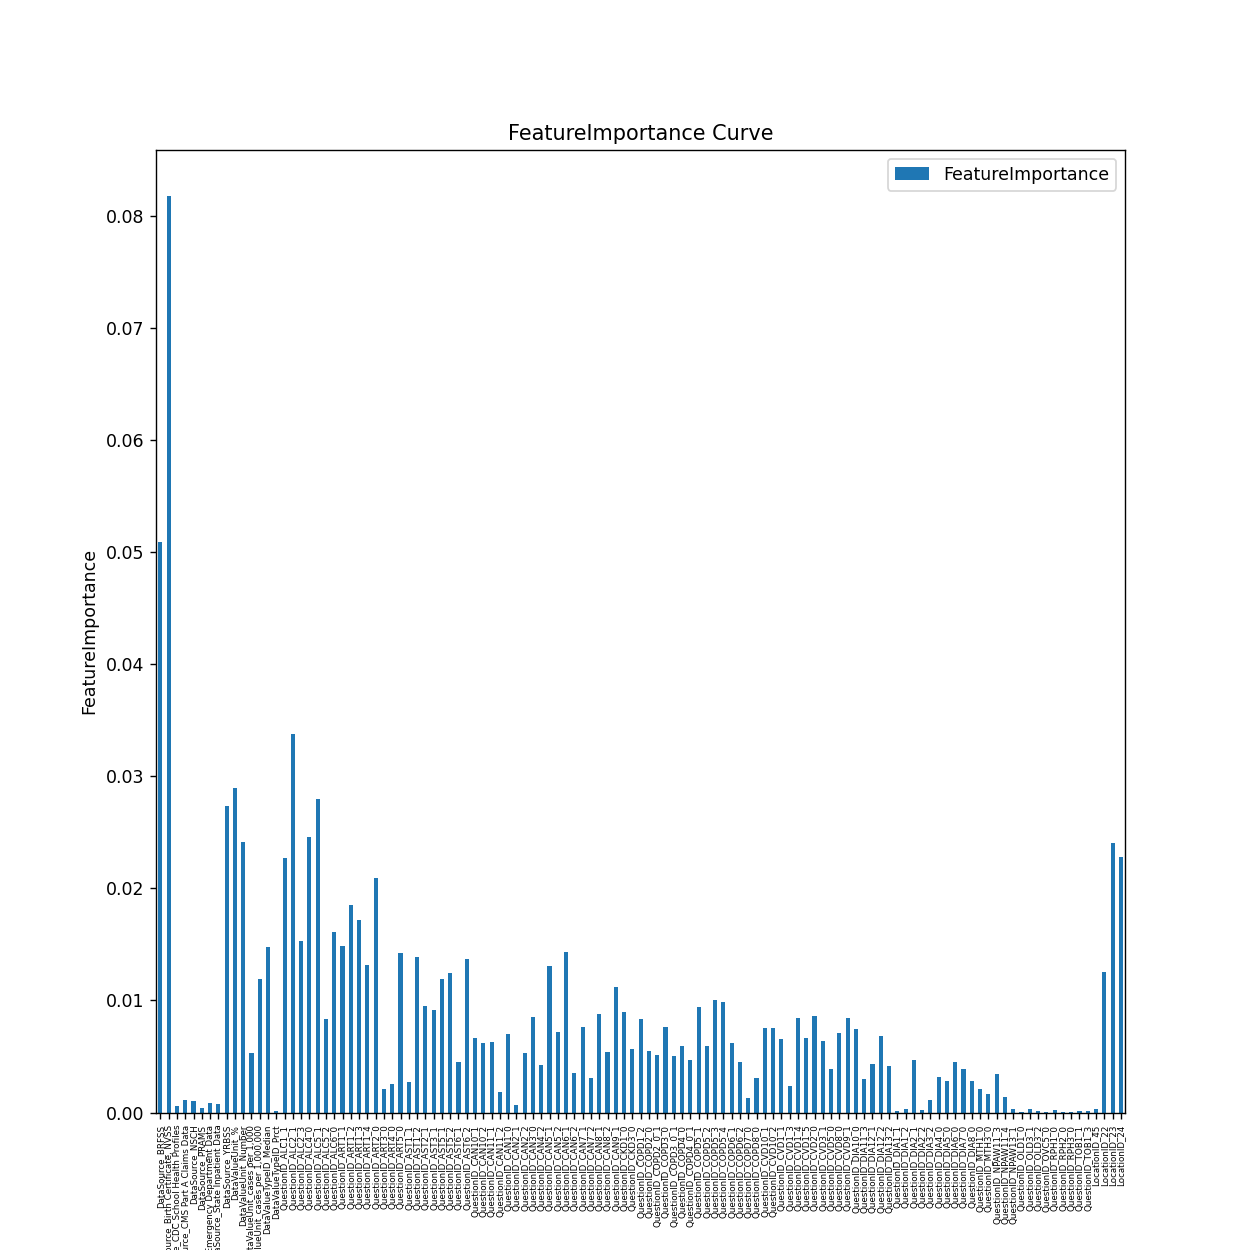

In [27]:
ax=df.plot.bar(figsize=(10,10),title='FeatureImportance Curve',ylabel='FeatureImportance',xlabel='Features')
ax.xaxis.set_tick_params(labelsize=5)